In [3]:
# 3/30/24 Multiplier 15 qubits
# This is utilzing Step 3, which means assessing it in a linear fashion during every ith increment
# calling qiskit packages, make sure to use qiskit v0.46.0 as that is the only version that supports execute_function
from qiskit import QuantumCircuit, Aer, execute
import json
import numpy as np
import matplotlib.pyplot as plt 

# defining all the variables here
Q = 15 # number of qubits
z = 0.1 # defining predetermined frequency value
R = 100 # Predetermined optimal atom replenishing value given by my mentor
nc = 1 # setting nc as a non-changing variable to help with the incrementation
S = Q * R # finding number of shots a circuit needs to run in total while assuming a linear relationship between qubits and shots
i = 1 # setting an ith increment which will help in determining the shot increments
x = int(i * z * S) # calculating increment proportional to total number of shots (S)
time = 30 # setting the normalization value
filename = "multiplier" # setting universal filename to avoid having to set differently
foldername = "Multiplier 15" # setting universal folder name to avoid having to change it anywhere else
benchmark = "QASMBench" # setting universal benchmark name to avoid having to change it everywhere else
bs_var_dict = {} # empty list to hold all values of bs_var to see how it changes over time
p_var_dict = {} # empty list to hold all vaues of p_var to see how it changes over time

# added variance function instead of having to run it seperately
def variance(shots, b_name, fo_name, f_name):
    # load the output distribution from the json file
    file_path = '/home/aadi/Documents/Neutral-Atom-Technology/Step 3/' + str(b_name) + '/' + str(fo_name) + '/' + str(f_name) + '_counts_' + str(shots) + '_shots.json' 
    with open(file_path, 'r') as file:
        output_distribution = json.load(file)

    # convert the dictionary keys to a list and probabilities to a separate list
    states = list(output_distribution.keys())
    probabilities = list(output_distribution.values())
    
    # this sets the probability values to add up to 1
    probabilities = [float(x)/float(shots) for x in probabilities]

    # random sampling of basis states based on probability and setting them equal to a list
    sample = np.random.choice(states, size=shots, p=probabilities)

    # random sampling of the probabilites list based on probabilty and setting them equal to a list
    prob_sample = np.random.choice(probabilities, size=shots, p=probabilities)

    # change binary to ints
    # int_sample = [int(b.replace(" ", ""), 2) for b in sample]
    int_sample = [int(b, 2) for b in sample]

    # calculating the variance and printing out the results
    sample_var = np.var(int_sample)
    # print("The sample variance is: " + str(sample_var))
    prob_var = np.var(prob_sample)
    # print("The sample variance using probability is : " + str(prob_var))
    
    return int(sample_var), prob_var


In [4]:
# reading qasm file
qc = QuantumCircuit.from_qasm_file(filename + "_n" + str(Q) + ".qasm")

# specifying which backend we will be using
backend = Aer.get_backend("statevector_simulator")


# simple while loop to calculate 
while x <= S:
    nc = x
    i += 1
    bs_var = 0 # variance using basis states converted into integers
    p_var = 0 # variance using probability 
    avg_bs_var = 0 # variable to calculate average variance of basis state 
    avg_p_var = 0 # variable to calculate average variance of proabilty
    
    # executing the circuit via backend
    job = execute(qc, backend, shots=x)
    result = job.result()

    # getting statevector results 
    statevector = result.get_statevector()
    # print(statevector)

    # getting counts (output distribution) of the simulation
    counts = result.get_counts(qc)

    # printing shot number to follow along
    # print(str(x))

    # logging the counts to a json file
    with open(filename + '_counts_' + str(int(x)) + '_shots.json', 'w', encoding='utf-8') as f:
        json.dump(counts, f, ensure_ascii=False, indent=4)

    # calculating the variance and normalizing it by running it 30 times and averaging it
    for t in range(1, time+1):
        temp_bs_var, temp_p_var = variance(int(x), benchmark, foldername, filename)
        bs_var += temp_bs_var
        p_var += temp_p_var
        avg_bs_var = int(bs_var / t)
        avg_p_var = p_var / t
        
    bs_var_dict[str(int(x))] = avg_bs_var
    p_var_dict[str(int(x))] = avg_p_var
        
    # print("\nThe average variance using probability is: " + str(avg_p_var))
    # print("The average variance using basis state converted to integers is: " + str(avg_bs_var))
    
    # moving up an increment
    x = nc + i*z*S
    


/tmp/ipykernel_24360/516370116.py:18: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc, backend, shots=x)


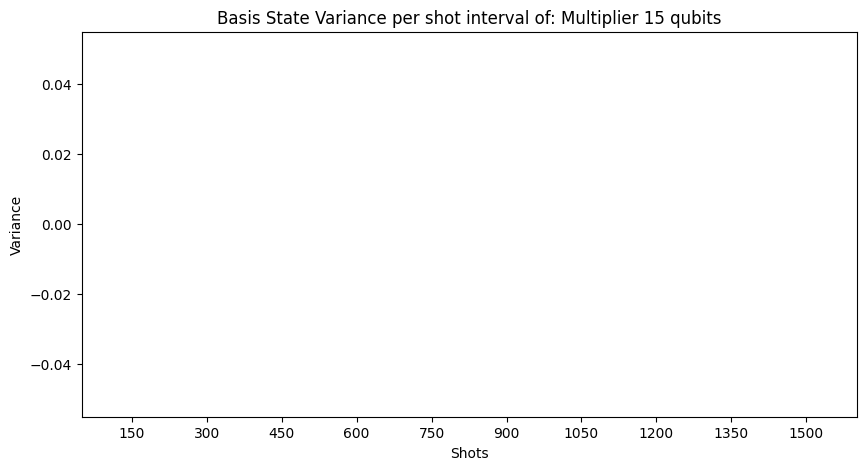

In [3]:
# splitting by counts and variance
shots = list(p_var_dict.keys())
variance = list(p_var_dict.values())

# setting the plot size
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(shots, variance, color ='blue', 
        width = 0.4)

# labeling the plot appropriately 
plt.xlabel("Shots")
plt.ylabel("Variance")
plt.title("Probability Variance per shot interval")
plt.show()

In [ ]:
# splitting by counts and variance of probability dictionary
shots = list(bs_var_dict.keys())
variance = list(bs_var_dict.values())

# setting the plot size
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(shots, variance, color ='red', 
        width = 0.4)

# labeling the plot appropriately 
plt.xlabel("Shots")
plt.ylabel("Variance")
plt.title("Basis State Variance per shot interval of: " + foldername + " qubits")
plt.show()